In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.preprocessing import image

In [2]:
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [11]:
def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


In [12]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [16]:
def deepdream(model, image_path, step_size=0.01, num_octave=3, octave_scale=1.4, iterations=20, max_loss=10.0):
    img = preprocess_image(image_path)
    original_shape = img.shape[1:3]
    successive_shapes = [original_shape]

    for i in range(1, num_octave):
        shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
        successive_shapes.append(shape)

    successive_shapes = successive_shapes[::-1]
    original_img = np.copy(img)
    shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

    for shape in successive_shapes:
        img = tf.image.resize(img, shape)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.keras.applications.inception_v3.preprocess_input(img)

        for i in range(iterations):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = calculate_loss(img, model)

            gradients = tape.gradient(loss, img)
            gradients /= tf.math.reduce_std(gradients) + 1e-8
            img += gradients * step_size
            img = tf.clip_by_value(img, -1, 1)

            if loss < max_loss:
                break

        # Upscale the smaller image to the next octave
        upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, img.shape[1:3])
        same_size_original = tf.image.resize(original_img, img.shape[1:3])
        lost_detail = same_size_original - upscaled_shrunk_original_img

        img += lost_detail
        shrunk_original_img = tf.image.resize(original_img, img.shape[1:3])

    img = deprocess_image(img.numpy())
    return img


In [17]:
def calculate_loss(img, model):
    activation = model(img)
    loss = tf.math.reduce_mean(activation)
    return loss

In [28]:
input_image = 'fantasy-3077928_1280.jpg'
dream_img = deepdream(model, input_image)


In [30]:
# Save the resulting image
save_path = 'dream_image.jpg'
image.save_img(save_path, dream_img[0])  # Accessing the first image in the batch


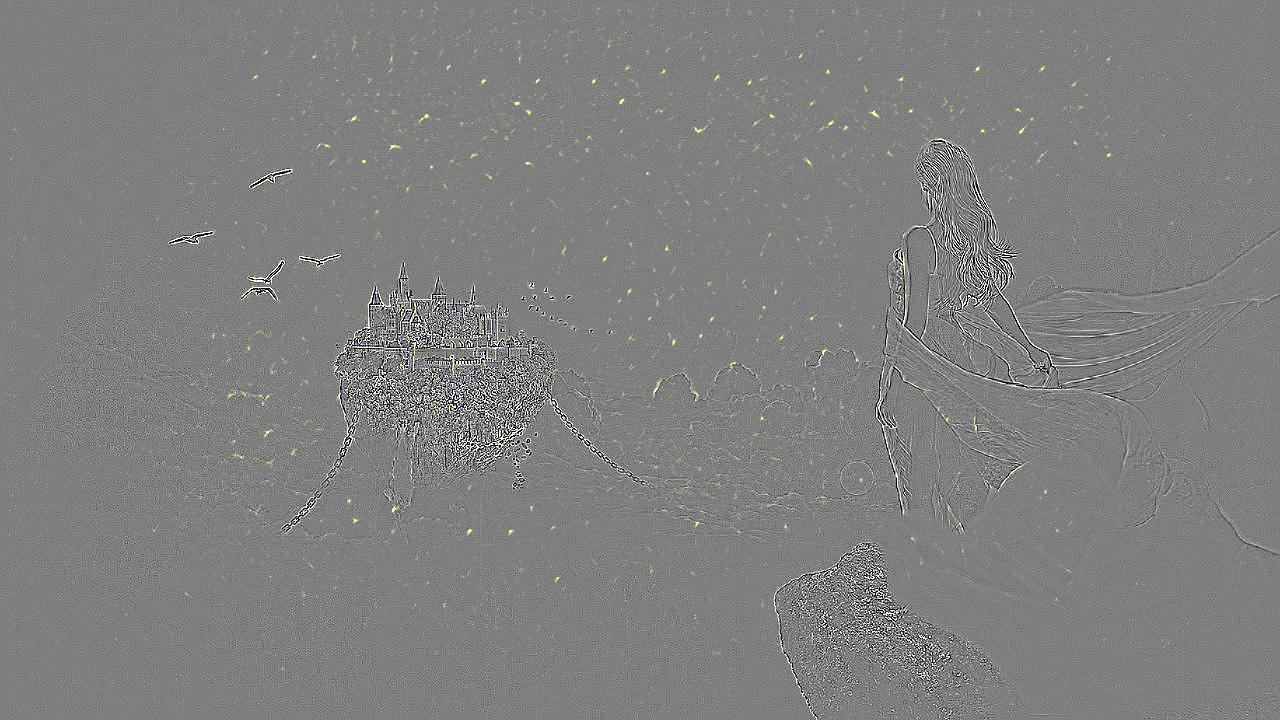

In [31]:
from IPython.display import Image, display
display(Image(save_path))
